In [1]:
import pylab
import numpy as np
import json
import networkx as nx
import random
import copy
import os

# useful additional packages
import numpy as np
import networkx as nx
import seaborn as sns
import time
import argparse
import mlflow

# Qiskit Imports
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA, NELDER_MEAD

# Custom Imports
from qaoa_vrp.features.graph_features import *
from qaoa_vrp.exp_utils import str2bool, make_temp_directory, to_snake_case
from qaoa_vrp.generators.graph_instance import GraphInstance
from qaoa_vrp.plot.draw_networks import draw_graph

In [2]:
# Number of nodes
N = 10
# Max iterations
MAX_ITERATIONS = 1000
# Number of restarts
N_RESTARTS = 1
track_mlflow = False

# Create a 3-regular graph (based on https://arxiv.org/pdf/2106.10055.pdf)
G_three_regular = GraphInstance(
    nx.random_regular_graph(d=3, n=N), graph_type="3-Regular Graph"
)


G_three_regular

This is a 3-Regular Graph Graph with 10 nodes and 15 edges graph instance

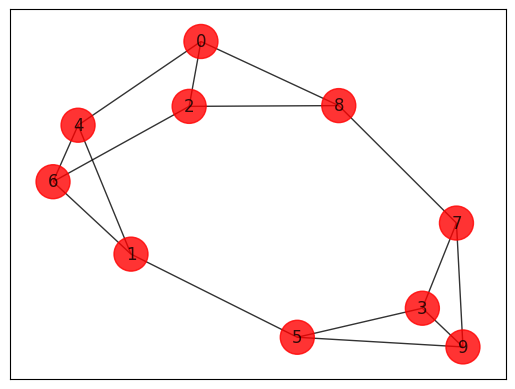

In [3]:
draw_graph(G_three_regular.G)

In [4]:
print(f"Solving Brute Force for {G_three_regular.graph_type}\n{'-'*50}\n")
G = G_three_regular.G

print(G_three_regular)
G_three_regular.allocate_random_weights()
G_three_regular.compute_weight_matrix()

Solving Brute Force for 3-Regular Graph
--------------------------------------------------

This is a 3-Regular Graph Graph with 10 nodes and 15 edges graph instance


In [5]:
print(G_three_regular.weight_matrix)

[[ 0.  0.  4.  0.  8.  0.  0.  0.  6.  0.]
 [ 0.  0.  0.  0.  8.  8.  7.  0.  0.  0.]
 [ 4.  0.  0.  0.  0.  0.  0.  0.  8.  0.]
 [ 0.  0.  0.  0.  0.  4.  0.  5.  0.  0.]
 [ 8.  8.  0.  0.  0.  0.  9.  0.  0.  0.]
 [ 0.  8.  0.  4.  0.  0.  0.  0.  0.  7.]
 [ 0.  7.  0.  0.  9.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  5.  0.  0.  0.  0.  4. 10.]
 [ 6.  0.  8.  0.  0.  0.  0.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  7.  0. 10.  0.  0.]]


In [6]:
G = G_three_regular.G
w = G_three_regular.weight_matrix
n = len(G.nodes())

In [7]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]

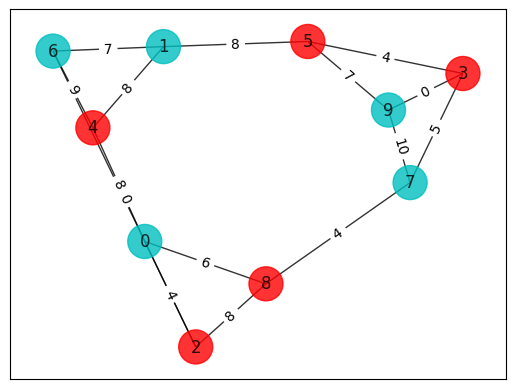

In [8]:
draw_graph(G, colors=colors)

In [9]:
max_cut = Maxcut(G_three_regular.weight_matrix)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -8*x_0*x_2 - 16*x_0*x_4 - 12*x_0*x_8 - 16*x_1*x_4 - 16*x_1*x_5 - 14*x_1*x_6
  - 16*x_2*x_8 - 8*x_3*x_5 - 10*x_3*x_7 - 18*x_4*x_6 - 14*x_5*x_9 - 8*x_7*x_8
  - 20*x_7*x_9 + 18*x_0 + 23*x_1 + 12*x_2 + 9*x_3 + 25*x_4 + 19*x_5 + 16*x_6
  + 19*x_7 + 18*x_8 + 17*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9



In [10]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -44.0
Ising Hamiltonian:
2.0 * IIIIIIIZIZ
+ 4.0 * IIIIIZIIIZ
+ 4.0 * IIIIIZIIZI
+ 4.0 * IIIIZIIIZI
+ 2.0 * IIIIZIZIII
+ 3.5 * IIIZIIIIZI
+ 4.5 * IIIZIZIIII
+ 2.5 * IIZIIIZIII
+ 3.0 * IZIIIIIIIZ
+ 4.0 * IZIIIIIZII
+ 2.0 * IZZIIIIIII
+ 3.5 * ZIIIZIIIII
+ 5.0 * ZIZIIIIIII


In [11]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print("\nBest solution BRUTE FORCE = "
    + str(xbest_brute)
    + " cost = "
    + str(best_cost_brute)
)


Best solution BRUTE FORCE = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0] cost = 76.0


In [12]:
print(f"\n{'-'*10} Checking that current Hamiltonian gives right cost {'-'*10}\n")


---------- Checking that current Hamiltonian gives right cost ----------



In [13]:
ee = NumPyMinimumEigensolver()

# Calculate the min eigenvalue
optimal_result = ee.compute_minimum_eigenvalue(qubitOp)

ground_state = max_cut.sample_most_likely(optimal_result.eigenstate)
print("ground state energy:", optimal_result.eigenvalue.real)
print("optimal max-cut objective:", optimal_result.eigenvalue.real + offset)
print("ground state solution:", ground_state)
print("ground state objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]


ground state energy: -32.0
optimal max-cut objective: -76.0
ground state solution: [1 0 1 0 0 1 1 1 0 0]
ground state objective: 0.0


In [14]:
print(f"\n{'-'*10} Simulating Instance on Quantum using VQE {'-'*10}\n")

# Run optimisation code
optimizer = COBYLA(maxiter=MAX_ITERATIONS)
num_qubits = qubitOp.num_qubits

init_state = np.random.rand(num_qubits) * 2 * np.pi
optimizer_results = []

result = {"algo": None, "result": None}

## Setting parameters for a run (Simulator Backend etc)
algorithm_globals.random_seed = 12321
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(
    backend, seed_simulator=seed, seed_transpiler=seed
)

print(f"The initial state is {init_state}")
print(f"Testing Optimizer {type(optimizer).__name__}")


---------- Simulating Instance on Quantum using VQE ----------

The initial state is [1.62680187 5.50144576 1.94544761 1.59011831 6.04060482 3.35604424
 4.92731988 5.30268277 5.22500827 1.08062544]
Testing Optimizer COBYLA


Running Optimization at n_restart=0
COBYLA iteration 100 	 cost function -5.903252299256671
COBYLA iteration 200 	 cost function -6.117659515929321
COBYLA iteration 300 	 cost function -6.2718901775922955
COBYLA iteration 400 	 cost function -6.357339370919704
COBYLA iteration 500 	 cost function -6.397741073494377
COBYLA iteration 600 	 cost function -6.422982657566125
COBYLA iteration 700 	 cost function -6.4372055606027665
COBYLA iteration 800 	 cost function -6.441929916558001
COBYLA iteration 900 	 cost function -6.444495830411081
COBYLA iteration 100 	 cost function -23.42242059850948
COBYLA iteration 200 	 cost function -27.97603615437033
COBYLA iteration 300 	 cost function -30.01052821893105
COBYLA iteration 400 	 cost function -31.510389755271596
COBYLA iteration 500 	 cost function -31.82374174638963
COBYLA iteration 600 	 cost function -31.927880129051932
COBYLA iteration 700 	 cost function -31.94773928356421
COBYLA iteration 800 	 cost function -31.969216054144745
COBYLA 

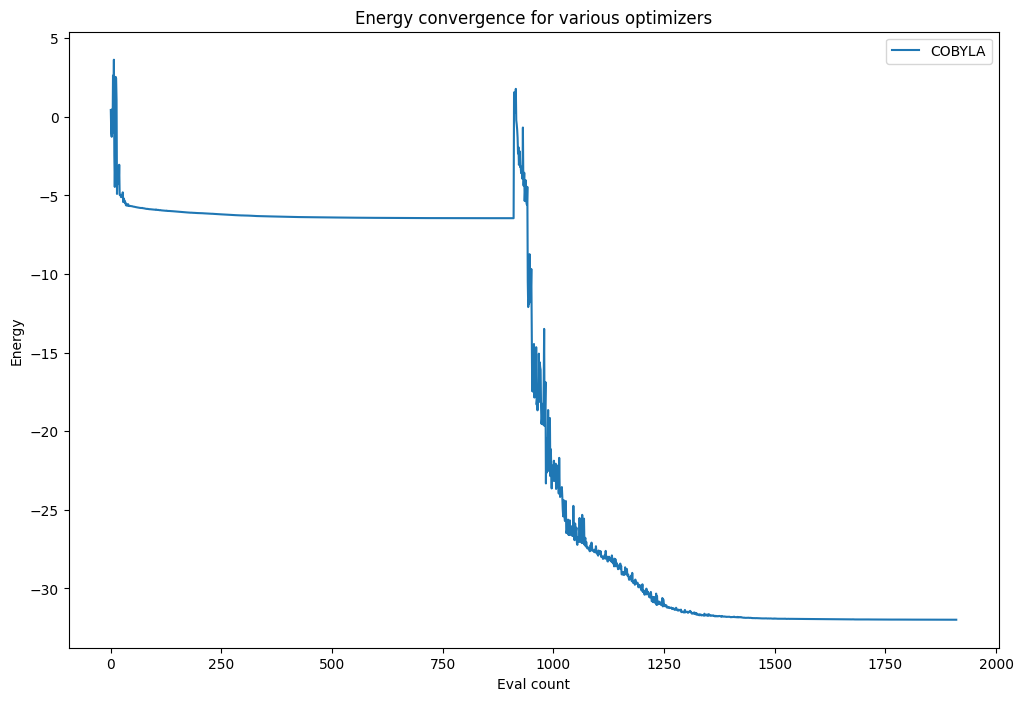

In [15]:
counts = []
values = []
algo = []

def store_intermediate_result(eval_count, parameters, mean, std):
    if track_mlflow:
        mlflow.log_metric(f"energy_{instance_type_logging}", mean)
    if eval_count % 100 == 0:
        print(
            f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}"
        )
    counts.append(eval_count)
    values.append(mean)

for restart in range(N_RESTARTS):
    print(f"Running Optimization at n_restart={restart}")
    init_state = np.random.rand(4) * 2 * np.pi

    # Define the systems of rotation for x and y
    ry = TwoLocal(num_qubits, "ry", "cz", reps=2, entanglement="linear")

    # VQE definition
    vqe = VQE(
        ry,
        optimizer=optimizer,
        quantum_instance=quantum_instance,
        callback=store_intermediate_result,
    )
    
    # QAOA definition
    qaoa = QAOA(
        optimizer=optimizer, 
        reps=2, 
        initial_point=init_state, 
        callback=store_intermediate_result, 
        quantum_instance=quantum_instance
    )
    
    qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)
    vqe_result = vqe.compute_minimum_eigenvalue(qubitOp)

# Convergence array
total_counts = np.arange(0, len(counts))
values = np.asarray(values)

print(f"\n{'-'*10} Optimization Complete {'-'*10}\n")

pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(total_counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right")

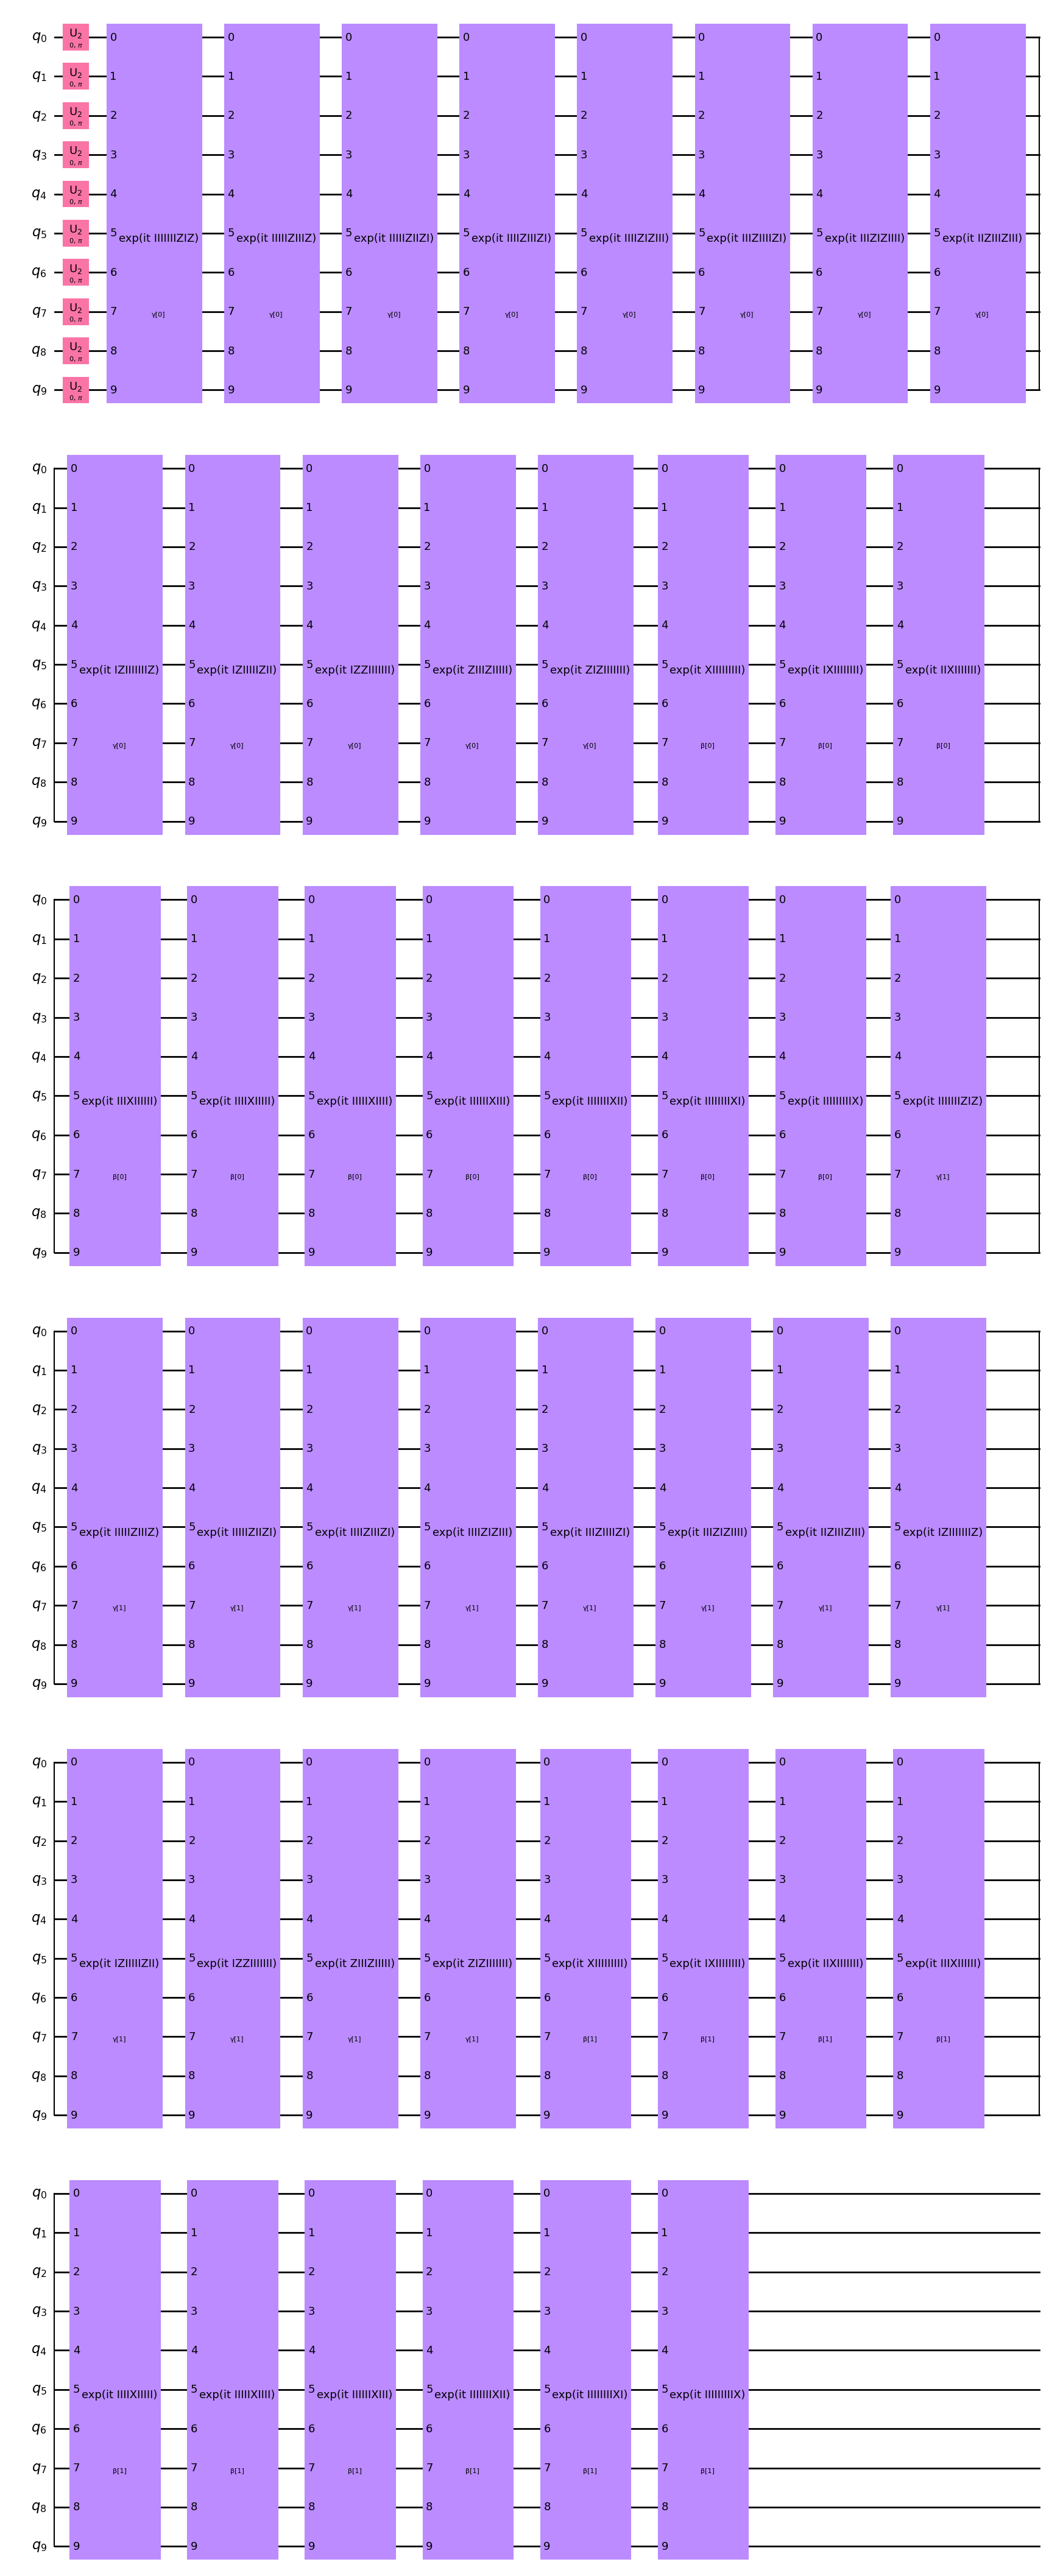

In [18]:
qaoa.ansatz.decompose().draw('mpl')

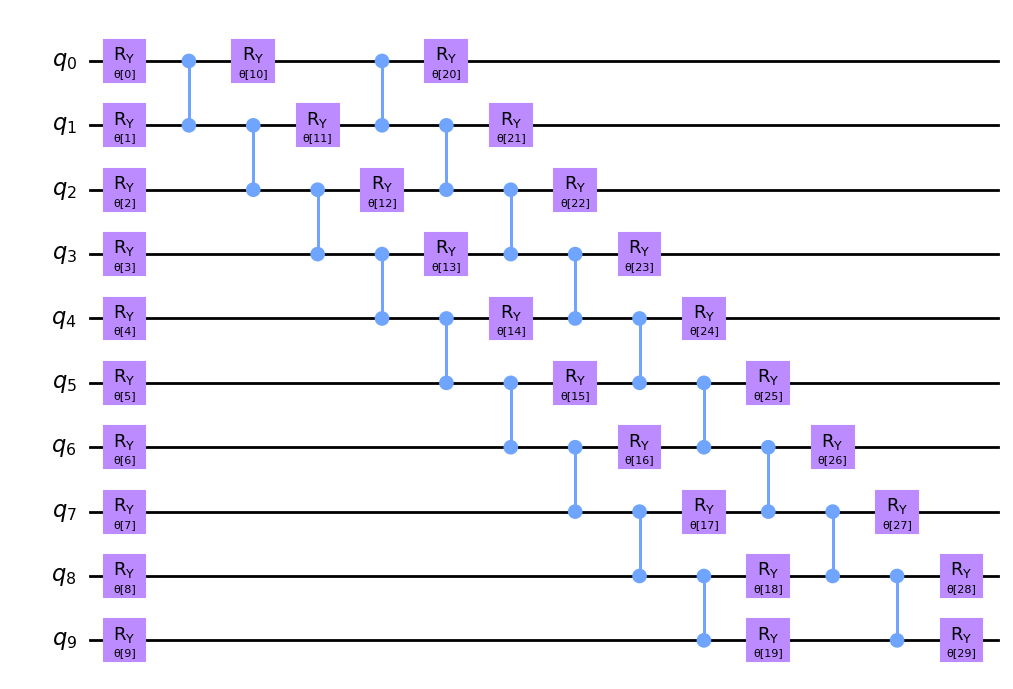

In [19]:
vqe.ansatz.decompose().draw('mpl')

## Filter VQE Circuit

In [20]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize


In [27]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_filter_vqe_circ(G, theta):
    """
    Creates a parametrized F-VQE circuit
    
    Args:  
        G: networkx graph
                     
    Returns:
        qc: qiskit circuit
    """
    nqubits = len(G.nodes())
#    theta = ParameterVector("$\\theta$", (2*nqubits - 1))
    p = 1
    qc = QuantumCircuit(nqubits)
    qc.h()
    for i in range(0, N):
        qc.ry(theta[i], i)

    for i in range(0, N):
        if i < (N-1):
            qc.cnot(i,i+1)
    for i in range(0, N):
        qc.ry(theta[i+9], i)
        
    # Measure across qubits
    qc.measure_all()
    return qc

def create_vqe_circ(G, theta):
    nqubits = len(G.nodes())
    ry = TwoLocal(nqubits, "ry", "cz", reps=2, entanglement="linear")

    # Get backend
    backend = Aer.get_backend("aer_simulator_statevector")
    quantum_instance = QuantumInstance(backend)

    # VQE definition
    vqe = VQE(
        ry,
        optimizer=COBYLA,
        quantum_instance=quantum_instance,
        callback=store_intermediate_result,
    )
    
    qc = vqe.ansatz.decompose()
    theta = np.random.random(len(qc.parameters))
    qc = qc.bind_parameters(theta)
    
    qc.measure_all()
    
    return qc
    

def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
    
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512, algorithm="fvqe"):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
        algorithm: 'fvqe', 'vqe', 'qaoa'
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    def execute_circ(theta):
        
        if algorithm == "qaoa":
            qc = create_qaoa_circ(G, theta)
        elif algorithm == "fvqe":
            qc = create_filter_vqe_circ(G, theta)
        elif algorithm == "vqe":
            qc = create_vqe_circ(G, theta)
        
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


In [28]:
expectation = get_expectation(G, algorithm="fvqe")
res = minimize(
    expectation, 
    np.random.random(2*N - 1), 
    method='COBYLA', 
    options={"maxiter":1000,"disp":True, "rhobeg":0.001},
    
)
res

     fun: -4.21484375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 70
  status: 1
 success: True
       x: array([0.99267605, 0.85811275, 0.29925481, 0.22441099, 0.1633877 ,
       0.35280589, 0.04521504, 0.31402788, 0.26677054, 0.9382136 ,
       0.82267035, 0.70610349, 0.70473327, 0.44176856, 0.23919295,
       0.9388431 , 0.80899596, 0.91558893, 0.03939528])

   Normal return from subroutine COBYLA

   NFVALS =   70   F =-4.214844E+00    MAXCV = 0.000000E+00
   X = 9.926761E-01   8.581127E-01   2.992548E-01   2.244110E-01   1.633877E-01
       3.528059E-01   4.521504E-02   3.140279E-01   2.667705E-01   9.382136E-01
       8.226704E-01   7.061035E-01   7.047333E-01   4.417686E-01   2.391929E-01
       9.388431E-01   8.089960E-01   9.155889E-01   3.939528E-02


In [23]:
expectation = get_expectation(G, algorithm="vqe")
res = minimize(
    expectation,
    None, 
    method='COBYLA', options={"maxiter":1000,"disp":True, "rhobeg":0.01})
res


   Normal return from subroutine COBYLA

   NFVALS =   13   F =-7.036133E+00    MAXCV = 0.000000E+00
   X =          NaN


     fun: -7.0361328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 13
  status: 1
 success: True
       x: array([nan])

In [24]:
expectation = get_expectation(G, algorithm="qaoa")
res = minimize(
    expectation, 
    np.random.random(2), 
    method='COBYLA', 
    options={"maxiter":1000,"disp":True, "rhobeg":0.001},
    
)
res


   Normal return from subroutine COBYLA

   NFVALS =   12   F =-6.454102E+00    MAXCV = 0.000000E+00
   X = 2.343007E-01   8.907717E-02


     fun: -6.4541015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 12
  status: 1
 success: True
       x: array([0.23430067, 0.08907717])

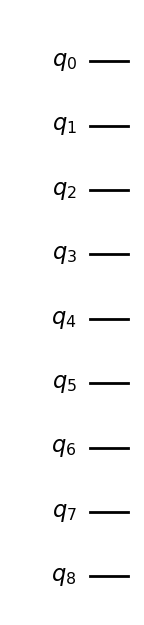

In [48]:
qc = QuantumCircuit(9)
qc.draw('mpl')

In [55]:
qc = create_filter_vqe_circ(G, np.random.random(18))

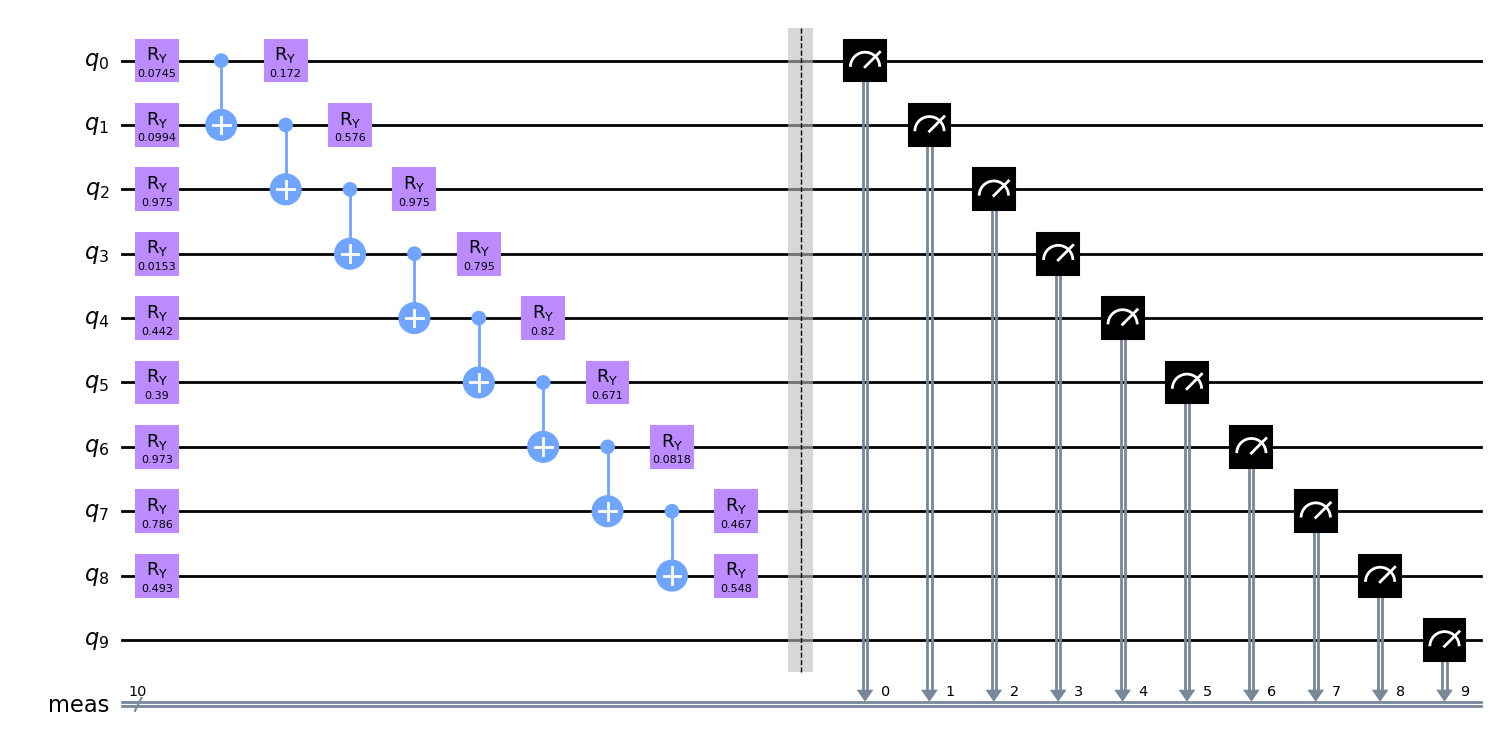

In [56]:
qc.draw('mpl')

In [60]:
backend = Aer.get_backend('qasm_simulator')
backend.shots = 512
counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()

In [61]:
counts

{'0000100101': 1,
 '0001001000': 1,
 '0111111011': 1,
 '0111101011': 1,
 '0110010010': 1,
 '0001110010': 1,
 '0010010000': 1,
 '0111000001': 1,
 '0010111110': 1,
 '0001110110': 1,
 '0001100110': 2,
 '0111100010': 2,
 '0100100111': 1,
 '0110010100': 3,
 '0100011100': 2,
 '0000101010': 2,
 '0000011100': 4,
 '0001111010': 1,
 '0010000000': 7,
 '0001101010': 1,
 '0111111000': 5,
 '0100010110': 1,
 '0110011000': 1,
 '0000001010': 2,
 '0000010100': 3,
 '0111010100': 2,
 '0001000100': 1,
 '0111101000': 9,
 '0110001100': 7,
 '0111100100': 14,
 '0001100000': 1,
 '0000100100': 11,
 '0100000000': 24,
 '0111010010': 1,
 '0010000010': 2,
 '0100101000': 2,
 '0100011000': 1,
 '0001111110': 2,
 '0110100010': 2,
 '0111011000': 1,
 '0100001101': 1,
 '0000011000': 8,
 '0001001100': 1,
 '0111111110': 10,
 '0111101110': 2,
 '0110110100': 1,
 '0001100100': 1,
 '0000000100': 25,
 '0010001000': 4,
 '0100010100': 1,
 '0000110010': 7,
 '0000000110': 2,
 '0000001000': 17,
 '0100111100': 6,
 '0000010010': 4,
 '00

In [231]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.circuit import Parameter
import numpy as np
import scipy
from scipy.optimize import minimize

# define the quantum circuit
def circuit(params):
    q = QuantumRegister(9)
    c = ClassicalRegister(9)
    qc = QuantumCircuit(q, c)

    # Apply the layer of Hadamard gates to all qubits
    for i in range(9):
        qc.h(q[i])

    # Apply the layer of RY rotations controlled by the parameters
    for i in range(8):
        qc.ry(params[i], q[i+1])

    # Apply the CNOT gates to construct the MAXCUT Hamiltonian
    for i in range(8):
        qc.cx(q[i], q[i+1])

    # Measure the final state of all qubits
    for i in range(9):
        qc.measure(q[i], c[i])
    
    return qc

# Define a cost function to evaluate the expectation value of the MAXCUT Hamiltonian
def cost_function(params):
    shots = 1024
    qc = circuit(params)
    result = execute(qc, backend, shots=shots).result()
    counts = result.get_counts()
    
    exp_value = 0
    for state, count in counts.items():
        x = [int(i) for i in state]
        exp_value += count * maxcut_objective_function(x)
    
    return -exp_value / shots
def maxcut_objective_function(x):
    # Define the MAXCUT objective function
    # Example for a 9-qubit instance
    weight_matrix = np.array([[0, 1, 1, 1, 1, 1, 1, 1, 1],
                              [1, 0, 1, 1, 1, 1, 1, 1, 1],
                              [1, 1, 0, 1, 1, 1, 1, 1, 1],
                              [1, 1, 1, 0, 1, 1, 1, 1, 1],
                              [1, 1, 1, 1, 0, 1, 1, 1, 1],
                              [1, 1, 1, 1, 1, 0, 1, 1, 1],
                              [1, 1, 1, 1, 1, 1, 0, 1, 1],
                              [1, 1, 1, 1, 1, 1, 1, 0, 1],
                              [1, 1, 1, 1, 1, 1, 1, 1, 0]])
    return sum([x[i] * x[j] * weight_matrix[i][j] for i in range(9) for j in range(i+1, 9)])

# Use the Scipy optimization method to find the optimal parameters
initial_params = np.random.rand(8) * np.pi
res = minimize(cost_function, initial_params, method='COBYLA')


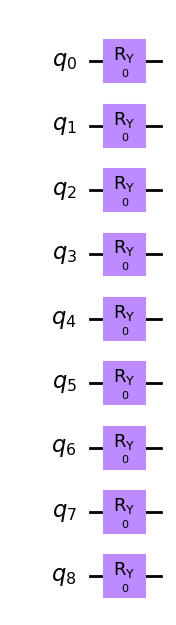

In [140]:
n_qubits=9
qc = QuantumCircuit(n_qubits)
qc.draw('mpl')
n_gates_layer_one = n_qubits
for i in range(n_gates_layer_one):
    qc.ry(0, i)
qc.draw('mpl')

In [141]:
#def add_parameterised_quantum_circut(qc):
i = 1
while i < qc.num_qubits:
    print(f"Adding on {i}")
    if i % 2 == 1:
        qc.cnot(i-1, i)
    qc.ry(0,i-1)
    i += 1

Adding on 1
Adding on 2
Adding on 3
Adding on 4
Adding on 5
Adding on 6
Adding on 7
Adding on 8


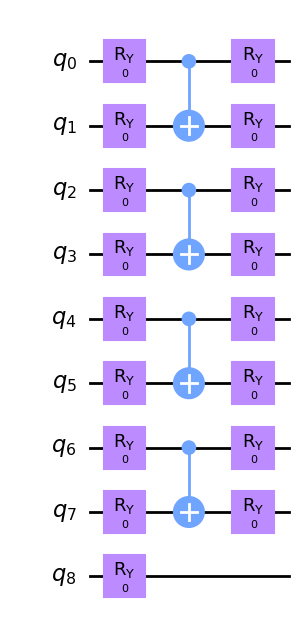

In [142]:
qc.draw('mpl')

In [143]:
#def add_parameterised_quantum_circut(qc):
i = 1
while i <= qc.num_qubits:
    if i % 2 == 0:
        qc.cnot(i-1, i)
    if i != 1:
        qc.ry(0,i-1)
    i += 1

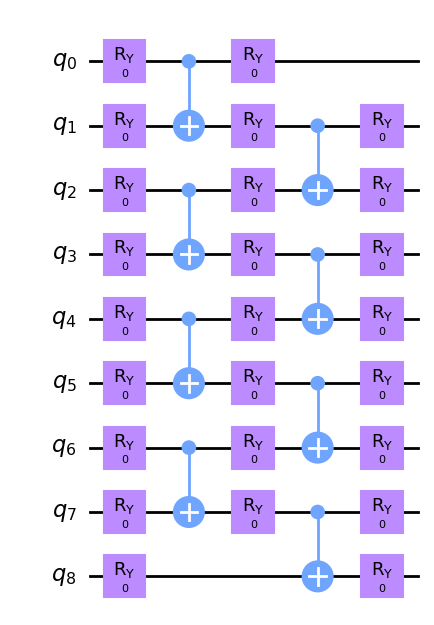

In [144]:
qc.draw('mpl')

In [186]:
n_qubits=9
qc = QuantumCircuit(n_qubits)

for i in range(n_qubits):
    qc.ry(0, i)


def add_fqe_layer(qc):
    qc.barrier()
    i = 1
    while i < qc.num_qubits:
        if i % 2 == 1:
            qc.cnot(i-1, i)
        qc.ry(0,i-1)
        i += 1

    #def add_parameterised_quantum_circut(qc):
    i = 1
    while i <= qc.num_qubits:
        if i % 2 == 0:
            qc.cnot(i-1, i)
        if i != 1:
            qc.ry(0,i-1)
        i += 1
    return qc


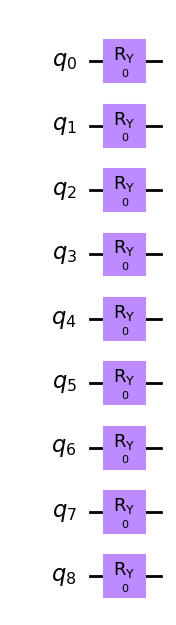

In [187]:
qc.draw('mpl')

In [188]:
qc = add_fqe_layer(qc)

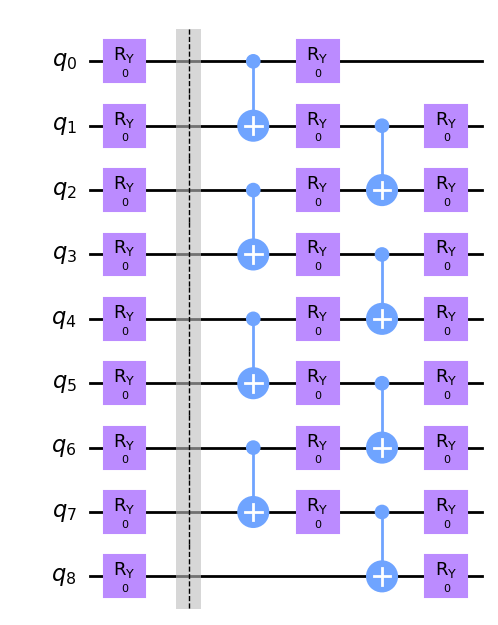

In [189]:
qc.draw('mpl')

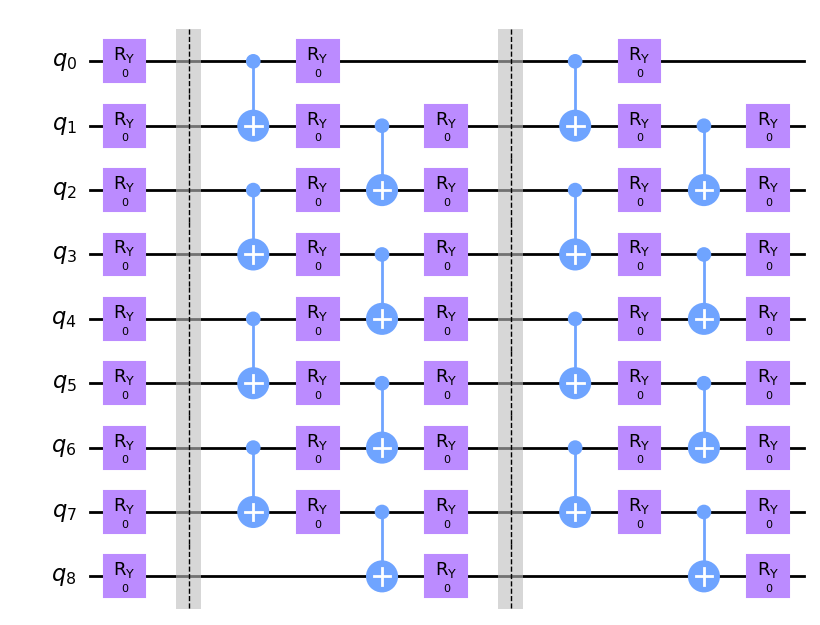

In [190]:
qc = add_fqe_layer(qc)
qc.draw('mpl')

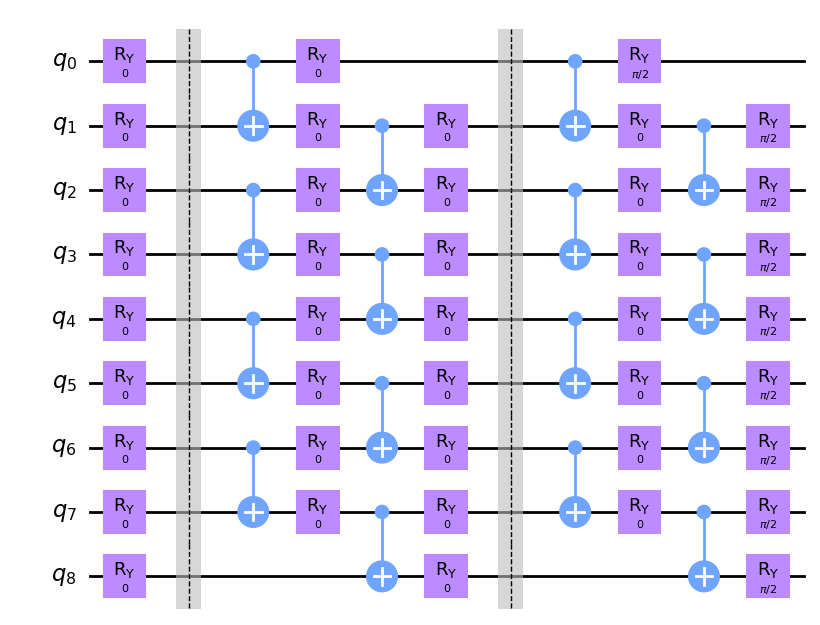

In [192]:
qc.draw('mpl')

In [254]:
n_qubits=9
layers = 1
def add_fqe_layer(qc, layer_num):
    qc.barrier()
    i = 1
    while i < qc.num_qubits:
        if i % 2 == 1:
            qc.cnot(i-1, i)
        fvqe_rot_param = Parameter(f'fvqe_{layer_num}_q[{i}]')
        qc.ry(fvqe_rot_param,i-1)
        i += 1

    i = 1
    while i <= qc.num_qubits:
        if i % 2 == 0:
            qc.cnot(i-1, i)
        if i != 1:
                    fvqe_rot_param = Parameter(f'fvqe_{layer_num}_q[{i}]') 
            qc.ry(0,i-1)
        i += 1
    return qc


def create_base_f_vqe_circuit(n_qubits, layers):
    
    # Create Quantum Circuit
    qc = QuantumCircuit(n_qubits)
    initial_rot_params = ParameterVector('a', n_qubits)
    for i in range(n_qubits):
        qc.ry(initial_rot_params[i], i)
    
    # Add F-VQE Layer
    for i in range(layers):
        qc = add_fqe_layer(qc, i)
    
    # Set the parameters on the last rotation of each qubit to pi/2
    gates = qc.data

    # Initialize a dictionary to store the last gate for each qubit
    last_gates = {}

    # Iterate over the gates in reverse order
    for gate in reversed(gates):
        # Check if the gate acts on multiple qubits
        if len(gate[1]) == 1:
            qubit = gate[1][0]
            # If the qubit is not in the dictionary, add it and set the gate
            if qubit not in last_gates:
                last_gates[qubit] = gate[0]

    # Modify the parameters of the last rotation for each qubit to pi/2
    for qubit in last_gates:
            last_gates[qubit]._params = (np.pi/2,)
    
    # Add final barrier
    qc.barrier()
    return qc

In [255]:
qc = create_base_f_vqe_circuit(9, layers=2)

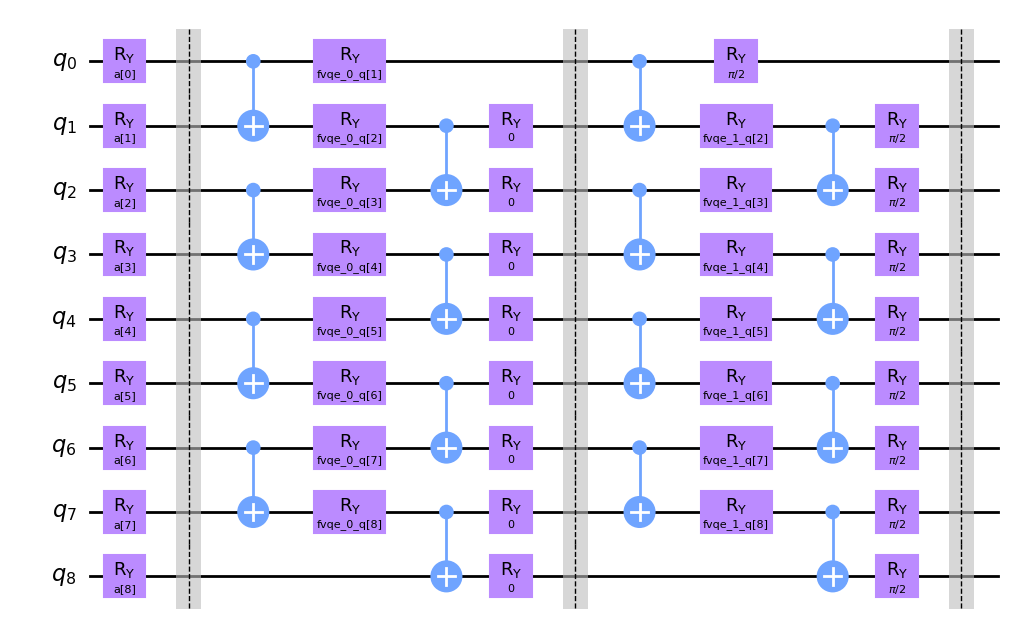

In [256]:
qc.draw('mpl')

In [219]:
counts = backend.run(qc, seed_simulator=10, 
                             nshots=1024).result().get_counts()

In [234]:
from qiskit.circuit import QuantumCircuit, Parameter
Parameter

qiskit.circuit.parameter.Parameter